# Sequence-to-Sequence Modeling using LSTM for Language Translation

Here,we will implement deep learning in the Sequence-to-Sequence (Seq2Seq) modelling for language translation. This approach will be applied to convert the short English sentences into the corresponding French sentences. The LSTM encoder and decoder are used to process the sequence to sequence modelling in this task. 

In [1]:
#Importing library
import numpy as np
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.utils import *
from keras.initializers import *
import tensorflow as tf
import time, random

In [2]:
#Hyperparameters
batch_size = 64
latent_dim = 256
num_samples = 10000

In [3]:
#Vectorize the data.
input_texts = []
target_texts = []
input_chars = set()
target_chars = set()

with open('../input/frenchenglish-bilingual-pairs/fra.txt', 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_chars:
            input_chars.add(char)
    for char in target_text:
        if char not in target_chars:
            target_chars.add(char)

input_chars = sorted(list(input_chars))
target_chars = sorted(list(target_chars))
num_encoder_tokens = len(input_chars)
num_decoder_tokens = len(target_chars)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

#Print size
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 93
Max sequence length for inputs: 16
Max sequence length for outputs: 59


In [4]:
#Define data for encoder and decoder
input_token_id = dict([(char, i) for i, char in enumerate(input_chars)])
target_token_id = dict([(char, i) for i, char in enumerate(target_chars)])

encoder_in_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype='float32')

decoder_in_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_in_data[i, t, input_token_id[char]] = 1.
    for t, char in enumerate(target_text):
        decoder_in_data[i, t, target_token_id[char]] = 1.
        if t > 0:
            decoder_target_data[i, t - 1, target_token_id[char]] = 1.


In [5]:
#Define and process the input sequence
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
#We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

#Using `encoder_states` set up the decoder as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [6]:
#Final model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [7]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 71)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 93)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 335872      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  358400      input_2[0][0]                    
                                                                 lstm[0][1]            

In [8]:
#Model data Shape
print("encoder_in_data shape:",encoder_in_data.shape)
print("decoder_in_data shape:",decoder_in_data.shape)
print("decoder_target_data shape:",decoder_target_data.shape)

encoder_in_data shape: (10000, 16, 71)
decoder_in_data shape: (10000, 59, 93)
decoder_target_data shape: (10000, 59, 93)


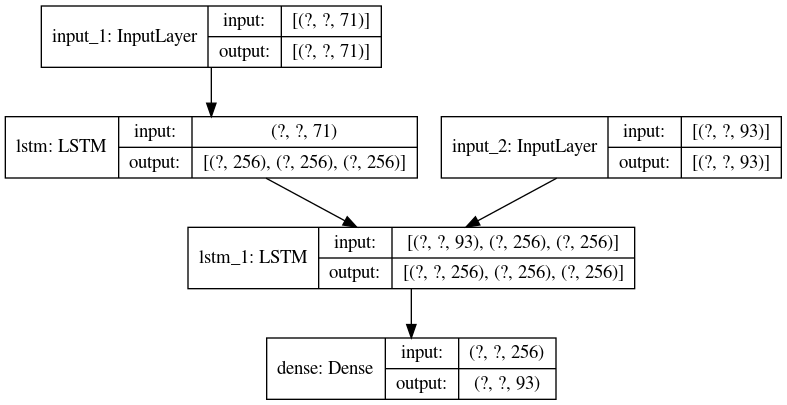

In [9]:
#Visuaize the model
plot_model(model,show_shapes=True)

In [10]:
from keras.optimizers import Adam

In [11]:
#Compiling and training the model
model.compile(optimizer=Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.001), loss='categorical_crossentropy')

model.fit([encoder_in_data, decoder_in_data], decoder_target_data, batch_size = batch_size, epochs=50, validation_split=0.2)

Epoch 1/50
125/125 [==============================] - 2s 16ms/step - loss: 0.7405 - val_loss: 0.6916
Epoch 2/50
125/125 [==============================] - 1s 9ms/step - loss: 0.5240 - val_loss: 0.5921
Epoch 3/50
125/125 [==============================] - 1s 9ms/step - loss: 0.4486 - val_loss: 0.5332
Epoch 4/50
125/125 [==============================] - 1s 9ms/step - loss: 0.3935 - val_loss: 0.4974
Epoch 5/50
125/125 [==============================] - 1s 9ms/step - loss: 0.3564 - val_loss: 0.4746
Epoch 6/50
125/125 [==============================] - 1s 9ms/step - loss: 0.3259 - val_loss: 0.4624
Epoch 7/50
125/125 [==============================] - 1s 9ms/step - loss: 0.3084 - val_loss: 0.4615
Epoch 8/50
125/125 [==============================] - 1s 9ms/step - loss: 0.2801 - val_loss: 0.4463
Epoch 9/50
125/125 [==============================] - 1s 9ms/step - loss: 0.2605 - val_loss: 0.4441
Epoch 10/50
125/125 [==============================] - 1s 9ms/step - loss: 0.2450 - val_loss: 0.445

In [12]:
#Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

The below part of codes will define the decode sequence for the text that we will pass to the model as the input sequence.

In [13]:
reverse_input_char_index = dict((i, char) for char, i in input_token_id.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_id.items())

#Define Decode Sequence
def decode_sequence(input_seq):
    #Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    #Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    #Get the first character of target sequence with the start character.
    target_seq[0, 0, target_token_id['\t']] = 1.

    #Sampling loop for a batch of sequences
    #(to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        #Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        #Exit condition: either hit max length
        #or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        #Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        #Update states
        states_value = [h, c]

    return decoded_sentence

Finally, we will check our model to decode the input sequence into the target sequence, i.e., translate the English sentences into the French sentences.

In [15]:
for seq_index in range(10):
    input_seq = encoder_in_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)
    print('Target sentences:', target_texts[seq_index])

-
Input sentence: Go.
Decoded sentence: Va doucement !

Target sentences: 	Va !

-
Input sentence: Run!
Decoded sentence: Arrêtez de jouer.

Target sentences: 	Cours !

-
Input sentence: Run!
Decoded sentence: Arrêtez de jouer.

Target sentences: 	Courez !

-
Input sentence: Wow!
Decoded sentence: Regarde-moi !

Target sentences: 	Ça alors !

-
Input sentence: Fire!
Decoded sentence: As-tu dormi ?

Target sentences: 	Au feu !

-
Input sentence: Help!
Decoded sentence: Salut tout le monde !

Target sentences: 	À l'aide !

-
Input sentence: Jump.
Decoded sentence: Dis juste oui !

Target sentences: 	Saute.

-
Input sentence: Stop!
Decoded sentence: Arrête de te quereller !

Target sentences: 	Ça suffit !

-
Input sentence: Stop!
Decoded sentence: Arrête de te quereller !

Target sentences: 	Stop !

-
Input sentence: Stop!
Decoded sentence: Arrête de te quereller !

Target sentences: 	Arrête-toi !

